In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from tqdm.notebook import tqdm

In [2]:
ads_url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/ads.csv'
currency_url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/currency.csv'
ads = pd.read_csv(ads_url, index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(currency_url, index_col=['Time'], parse_dates=['Time'])
ads.head(), currency.head()

(                        Ads
 Time                       
 2017-09-13 00:00:00   80115
 2017-09-13 01:00:00   79885
 2017-09-13 02:00:00   89325
 2017-09-13 03:00:00  101930
 2017-09-13 04:00:00  121630,
             GEMS_GEMS_SPENT
 Time                       
 2017-05-01          1199436
 2017-05-02          1045515
 2017-05-03           586111
 2017-05-04           856601
 2017-05-05           793775)

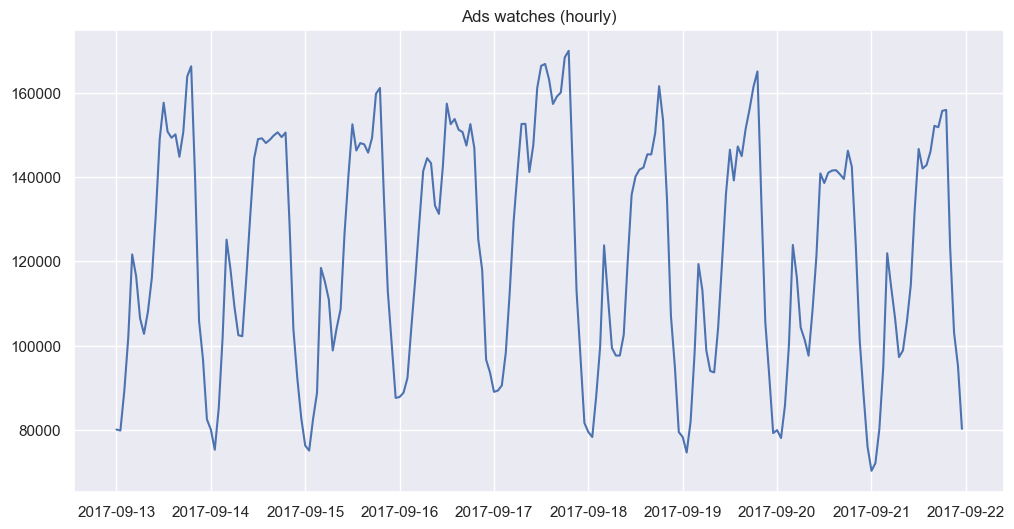

In [12]:
sns.set()
plt.figure(figsize=(12,6))
plt.plot(ads.Ads)
plt.title('Ads watches (hourly)')
plt.grid(True)

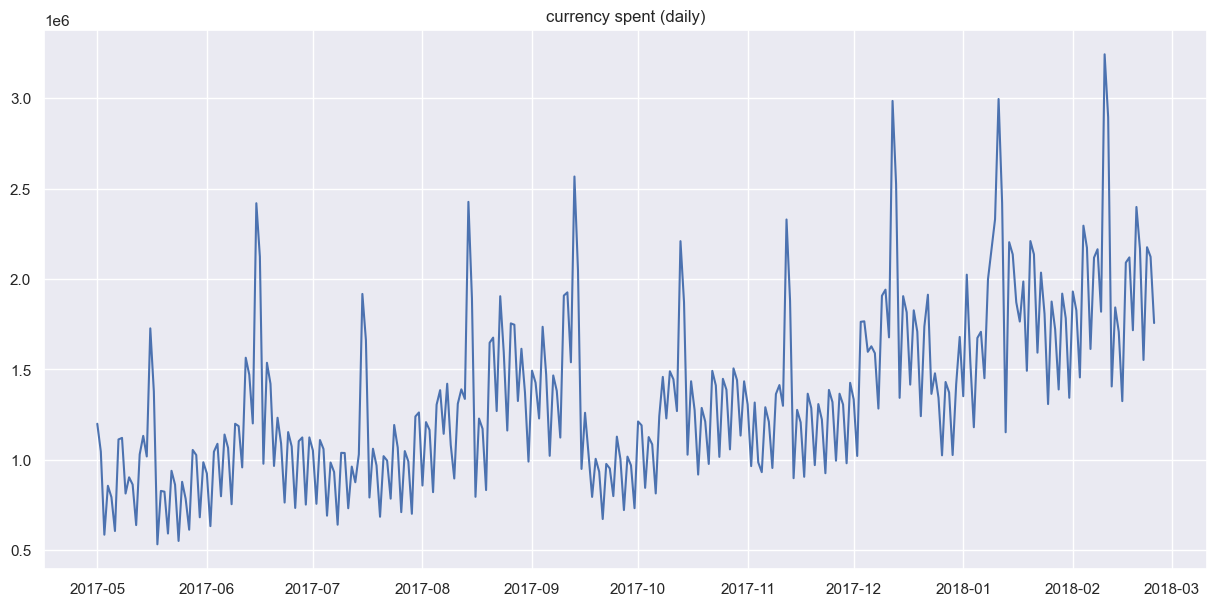

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title("currency spent (daily)")
plt.grid(True)

In [14]:
def moving_average(series, n):
    return np.average(series[-n:])


moving_average(ads, 5)

111561.0

In [26]:
from sklearn.metrics import mean_absolute_error

def plot_moving_average(series, window, plot_intervals=False, scale=2, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(16,6))
    plt.title('moving avg win size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='rm trend')
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, 'r--', label='Upper / Lower bond')
        plt.plot(lower_bond, 'r--')
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, 'ro', markersize=10)
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='upper left')
    plt.grid(True)

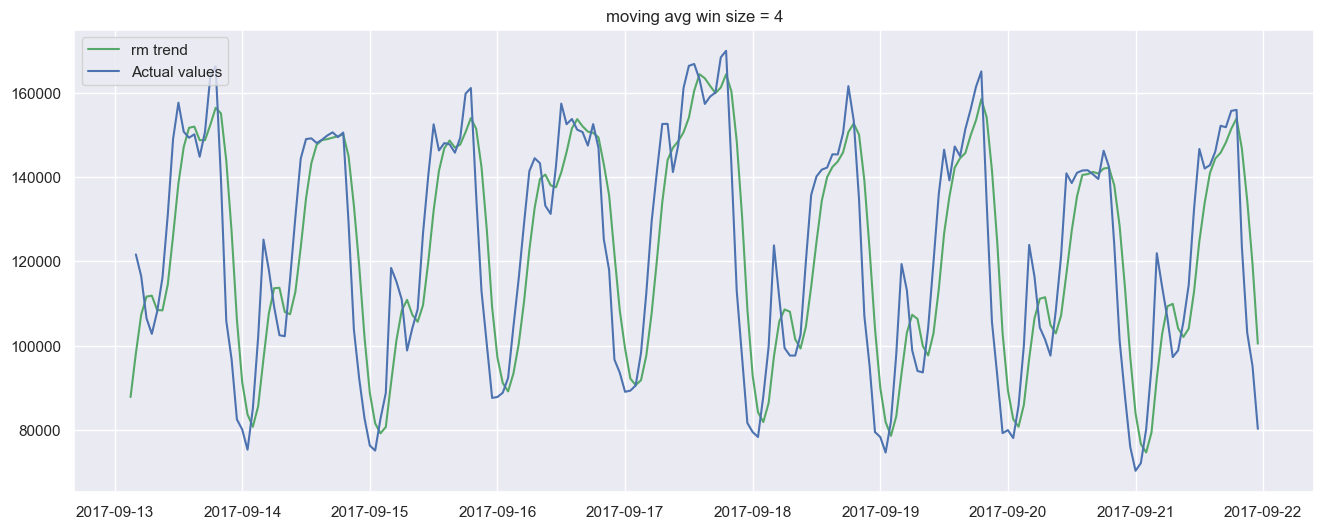

In [18]:
plot_moving_average(ads, 4)

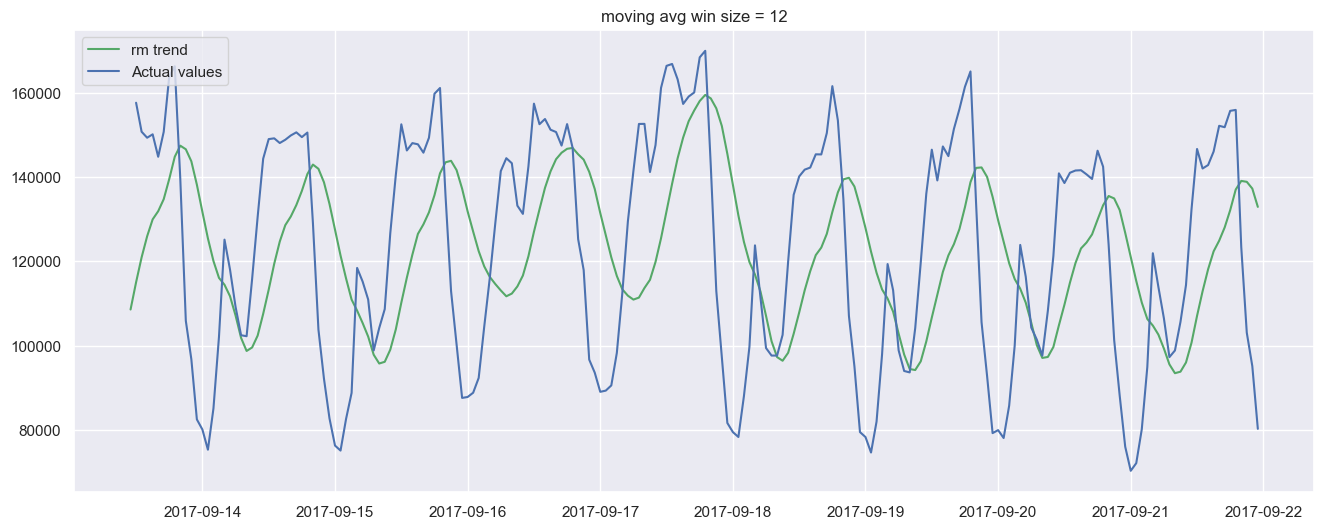

In [19]:
plot_moving_average(ads, 12)

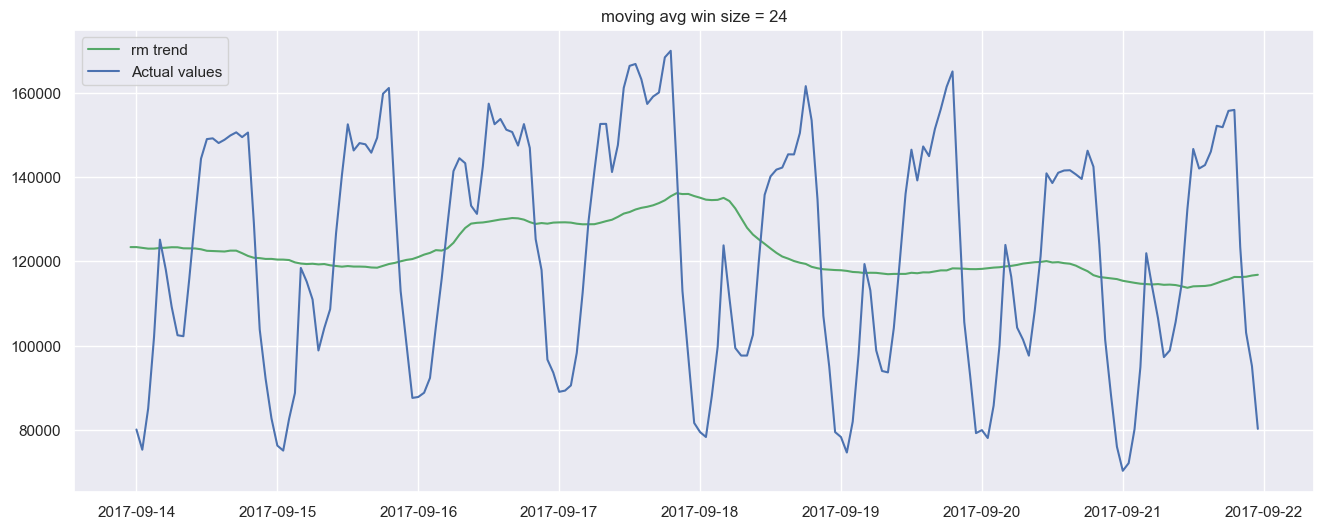

In [20]:
plot_moving_average(ads, 24)

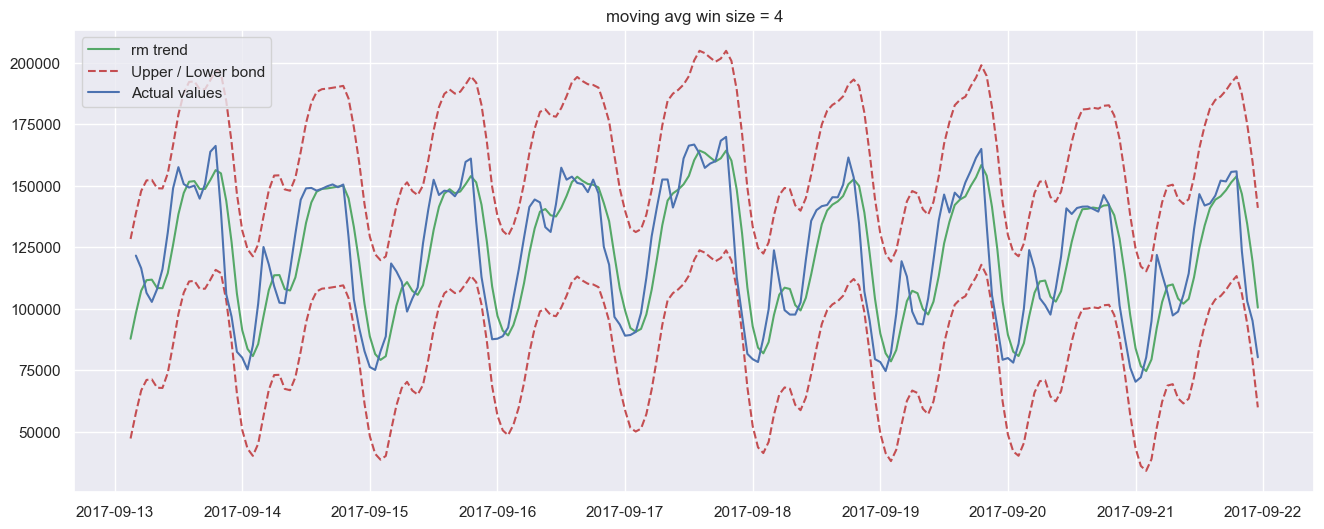

In [23]:
plot_moving_average(ads, 4, plot_intervals=True)

In [24]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2

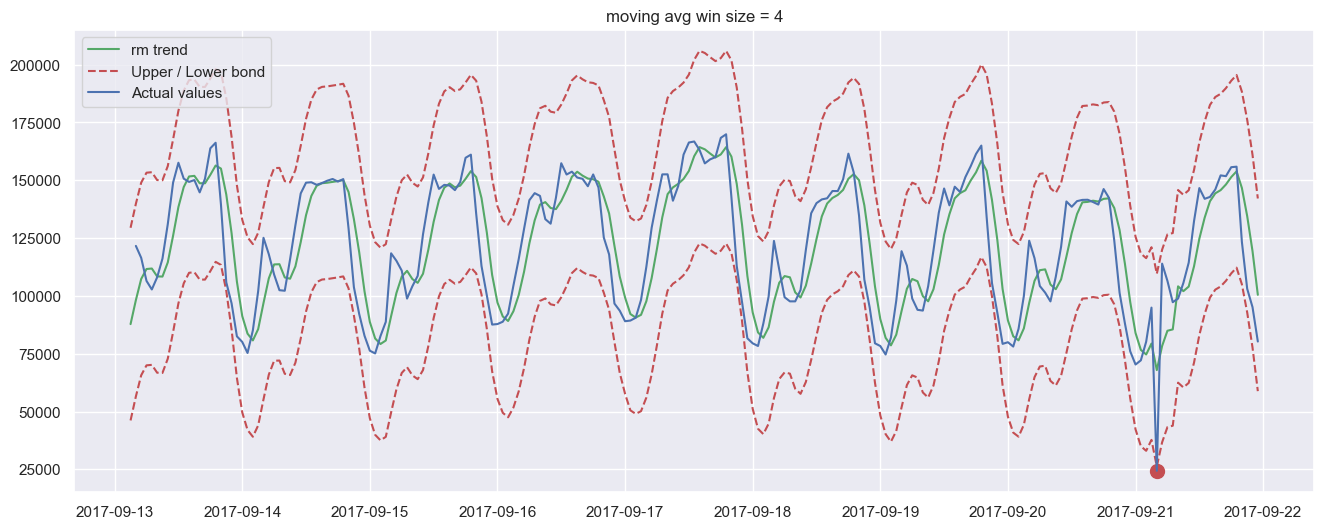

In [28]:
plot_moving_average(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

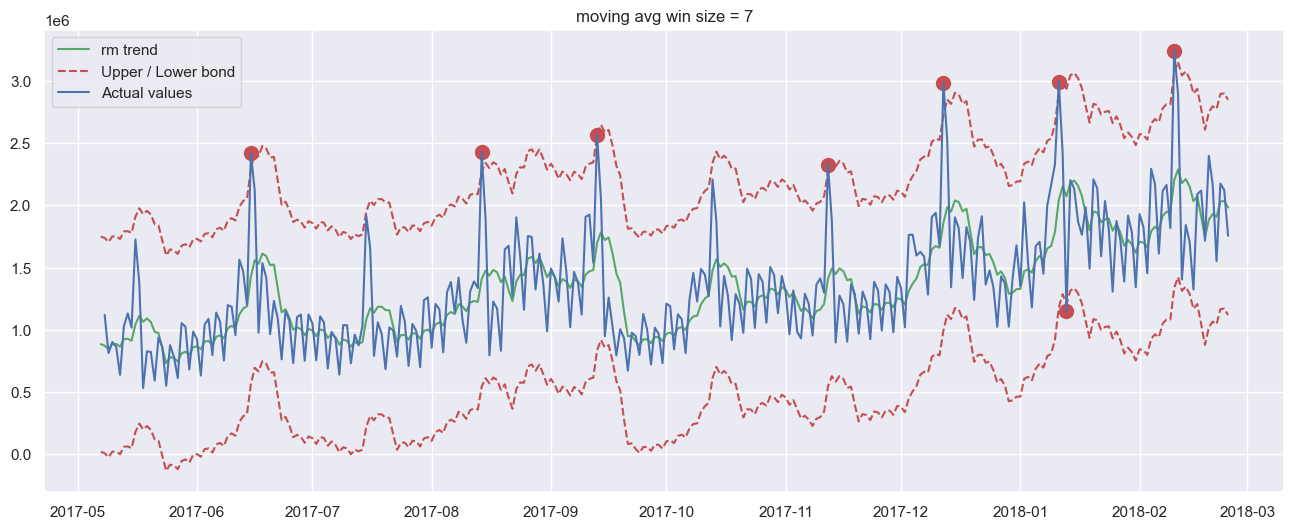

In [29]:
plot_moving_average(currency, 7, plot_intervals=True, plot_anomalies=True)

In [35]:
def weighted_average(series, weights):
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)
    
    
weighted_average(ads, [0.6, 0.3, 0.1])

87025.5

In [36]:
0.6 * ads.iloc[-1] + 0.3 * ads.iloc[-2] + 0.1 * ads.iloc[-3]

Ads    87025.5
dtype: float64

In [45]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1-alpha) * result[n-1])
    return result

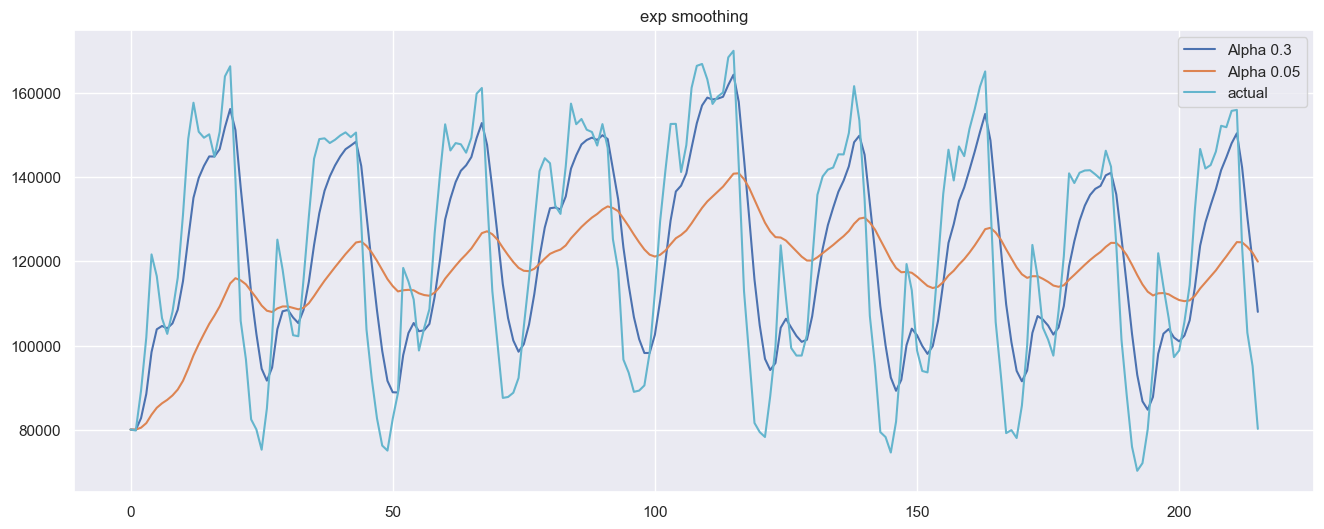

In [46]:
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(16,6))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
    plt.plot(series.values, 'c', label='actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('exp smoothing')
    plt.grid(True)
    
    
plot_exponential_smoothing(ads.Ads, [0.3, 0.05])

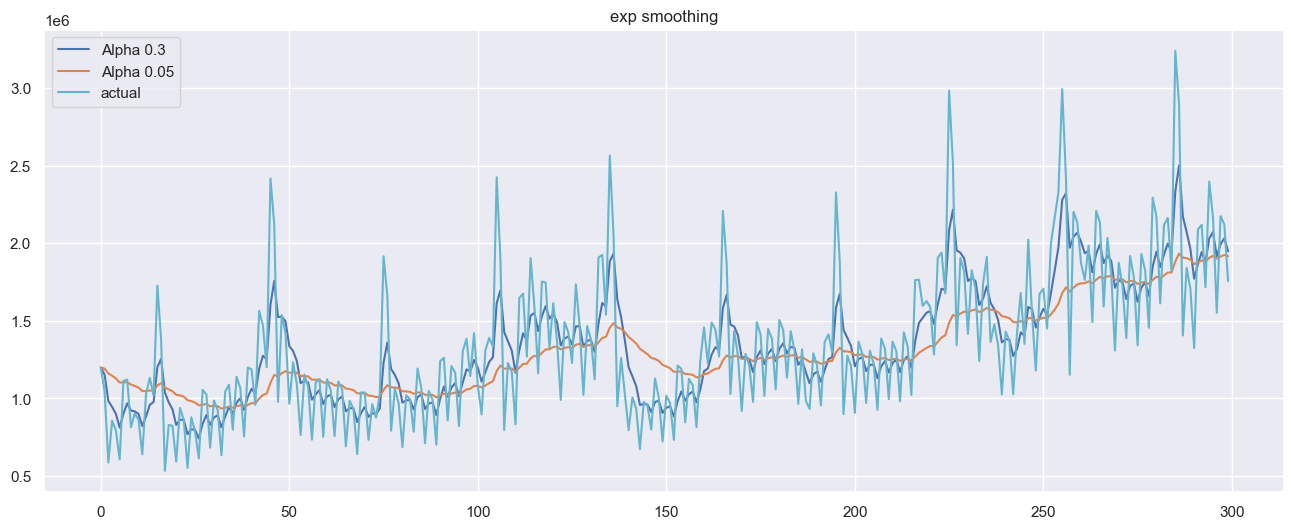

In [48]:
plot_exponential_smoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error
0
def timeseries_cv_score(params, series, loss_function=mean_squared_error, slen=24):
    errors = []
    values = series.values
    alpha, beta, gamma = params
    ts = TimeSeriesSplit(n_splits=3)
    
    for train, test in ts.split(values):
        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test)
        )
        model.triple_exponential_smoothing()
        
        preds = model.result[-len(test):]
        actual = values[test]
        error = loss_function(preds, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
data = ads.Ads[:-20]
x = [0,0,0]

opt = minimize(
    timeseries_cv_score,
    x0=x,
    args=(data, mean_squared_log_error),
    method='TNC',
    bounds=((0,1), (0,1), (0,1))
)

a_final, b_final, g_final = opt.x
print(a_final, b_final, g_final)

model = HoltWinters(
    data,
    slen=24,
    alpha=a_final,
    beta=b_final,
    gamma=g_final,
    n_preds=50,
    scaling_factor=3
)
model.triple_exponential_smoothing()

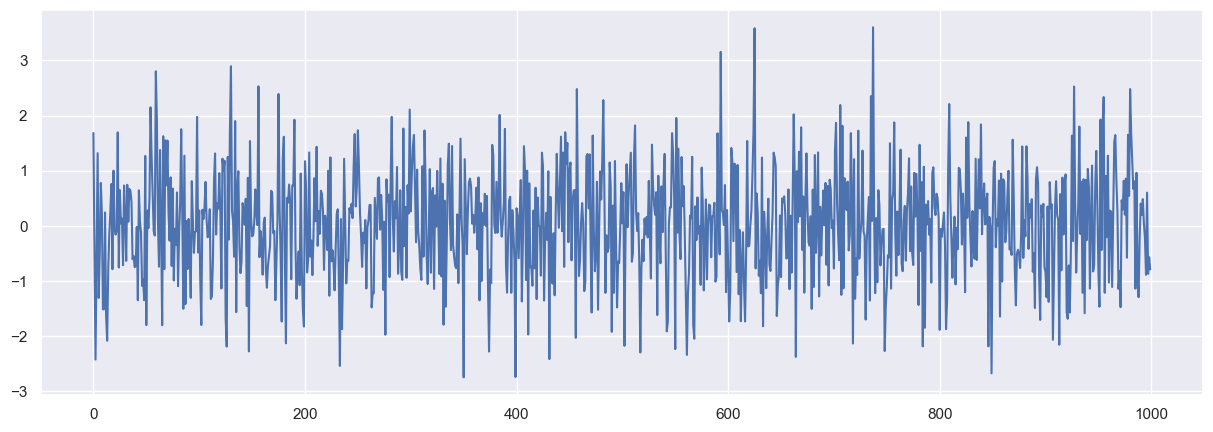

In [58]:
white_noise = np.random.normal(size=1000)
plt.figure(figsize=(15,5))
plt.plot(white_noise)

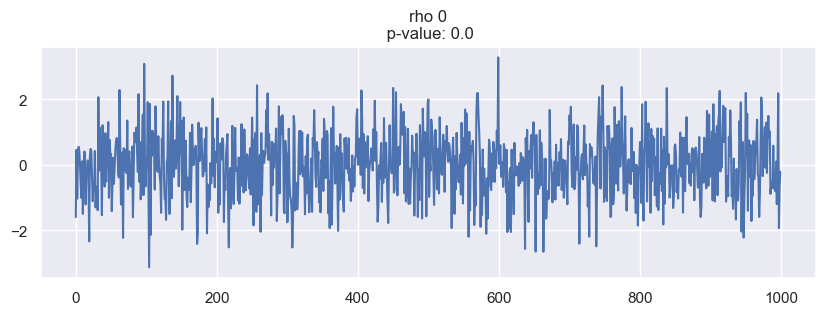

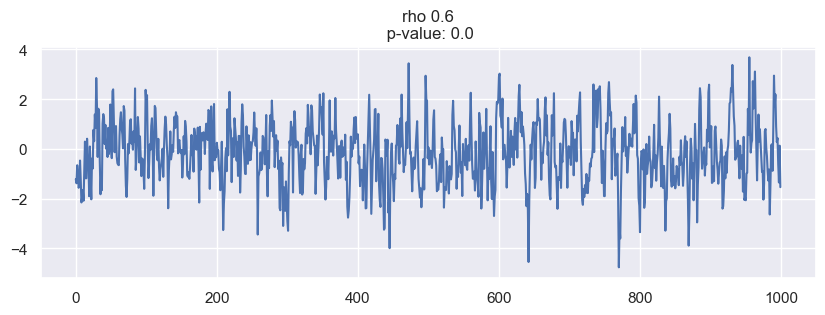

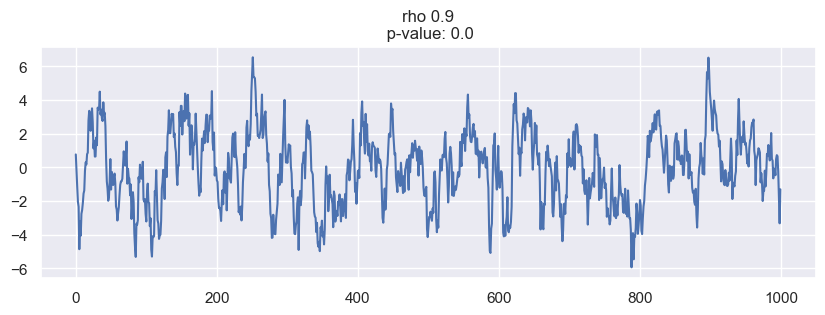

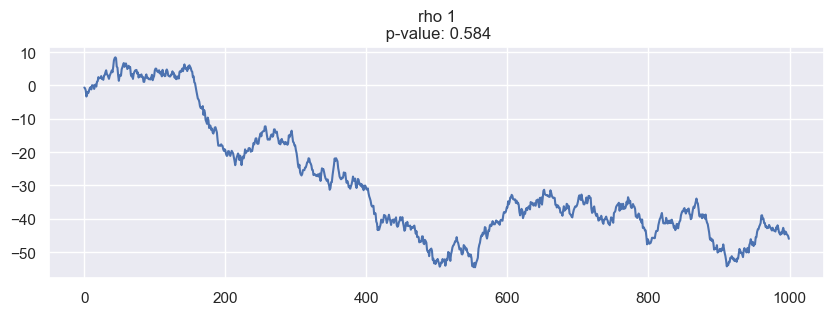

In [60]:
def plot_process(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
    
    plt.figure(figsize=(10,3))
    plt.plot(x)
    plt.title('rho {}\n p-value: {}'.format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
    
for rho in [0, 0.6, 0.9, 1]:
    plot_process(rho=rho)

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# https://drive.google.com/uc?id=1et3FfGQzm_lw0AWtZ0125TKKbD6dTwdi
df = pd.read_csv('./data/medium_posts.csv', sep='\t')
df.head()

published           domain  \
0  2012-08-13 22:54:53.510Z       medium.com   
1  2012-08-13 22:57:17.248Z       medium.com   
2  2016-11-04 23:40:43.364Z       medium.com   
3  2016-12-24 18:21:13.427Z       medium.com   
4  2015-09-22 21:37:48.207Z  blog.medium.com   

                                                 url  
0  https://medium.com/policy/medium-terms-of-serv...  
1  https://medium.com/policy/medium-privacy-polic...  
2  https://medium.com/@Medium/personalize-your-me...  
3  https://medium.com/holiday-poems/xmas-morning-...  
4  https://blog.medium.com/taking-a-side-on-net-n...

In [5]:
df = df[['published', 'url']].dropna().drop_duplicates()
df.head()

published                                                url
0  2012-08-13 22:54:53.510Z  https://medium.com/policy/medium-terms-of-serv...
1  2012-08-13 22:57:17.248Z  https://medium.com/policy/medium-privacy-polic...
2  2016-11-04 23:40:43.364Z  https://medium.com/@Medium/personalize-your-me...
3  2016-12-24 18:21:13.427Z  https://medium.com/holiday-poems/xmas-morning-...
4  2015-09-22 21:37:48.207Z  https://blog.medium.com/taking-a-side-on-net-n...

In [6]:
df['published'] = pd.to_datetime(df.published)
df.head()

published  \
0 2012-08-13 22:54:53.510000+00:00   
1 2012-08-13 22:57:17.248000+00:00   
2 2016-11-04 23:40:43.364000+00:00   
3 2016-12-24 18:21:13.427000+00:00   
4 2015-09-22 21:37:48.207000+00:00   

                                                 url  
0  https://medium.com/policy/medium-terms-of-serv...  
1  https://medium.com/policy/medium-privacy-polic...  
2  https://medium.com/@Medium/personalize-your-me...  
3  https://medium.com/holiday-poems/xmas-morning-...  
4  https://blog.medium.com/taking-a-side-on-net-n...

In [7]:
df.sort_values('published').head()

published  \
50931 1970-01-01 00:00:00.001000+00:00   
40243 1970-01-01 00:00:00.001000+00:00   
37395 1970-01-18 05:11:46.500000+00:00   
37398 1970-01-18 05:11:58.200000+00:00   
37394 1970-01-18 05:26:42.120000+00:00   

                                                     url  
50931                            https://medium.com/iiot  
40243  https://medium.com/@ikaella/melon-rebranding-b...  
37395  http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...  
37398  http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...  
37394  http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...

In [12]:
df = df[df.published > '2012-08-15'].sort_values('published')
df

published  \
24630 2012-08-15 00:25:03.373000+00:00   
24631 2012-08-15 00:25:29.419000+00:00   
17811 2012-08-15 00:34:59.502000+00:00   
17281 2012-08-15 00:40:10.773000+00:00   
12376 2012-08-15 00:58:25.898000+00:00   
...                                ...   
91448 2017-06-27 11:26:33.629000+00:00   
86599 2017-06-27 12:01:15.006000+00:00   
89538 2017-06-27 12:16:47.649000+00:00   
90927 2017-06-27 13:01:27.795000+00:00   
90673 2017-06-27 14:48:42.850000+00:00   

                                                     url  
24630  https://medium.com/launch-day/jean-attempts-to...  
24631  https://medium.com/launch-day/dan-and-kristin-...  
17811  https://medium.com/i-m-h-o/the-world-is-social...  
17281  https://medium.com/@karen/this-farm-table-1cfc...  
12376  https://medium.com/@hattmodgins/lighting-strik...  
...                                                  ...  
91448  https://medium.com/@techgenyz/eu-fines-google-...  
86599  https://medium.com/revista-subjetiva/nem-tudo-...  
89538  https://medium.com/blog-do-andre-sobreiro/di%C...  
90927  https://medium.com/@AdsNative/pocketmath-reduc...  
90673  https://medium.com/@charliedeets/thoughts-on-t...  

[92049 rows x 2 columns]

In [13]:
gb = df.groupby('published')[['url']].count()
gb.columns = ['posts']
gb

posts
published                              
2012-08-15 00:25:03.373000+00:00      1
2012-08-15 00:25:29.419000+00:00      1
2012-08-15 00:34:59.502000+00:00      1
2012-08-15 00:40:10.773000+00:00      1
2012-08-15 00:58:25.898000+00:00      1
...                                 ...
2017-06-27 11:26:33.629000+00:00      1
2017-06-27 12:01:15.006000+00:00      1
2017-06-27 12:16:47.649000+00:00      1
2017-06-27 13:01:27.795000+00:00      1
2017-06-27 14:48:42.850000+00:00      1

[91934 rows x 1 columns]

In [15]:
daily_df = gb.resample('D').agg(['sum'])
daily_df

posts
                            sum
published                      
2012-08-15 00:00:00+00:00    16
2012-08-16 00:00:00+00:00    11
2012-08-17 00:00:00+00:00     4
2012-08-18 00:00:00+00:00     2
2012-08-19 00:00:00+00:00     1
...                         ...
2017-06-23 00:00:00+00:00   421
2017-06-24 00:00:00+00:00   277
2017-06-25 00:00:00+00:00   253
2017-06-26 00:00:00+00:00   207
2017-06-27 00:00:00+00:00    36

[1778 rows x 1 columns]

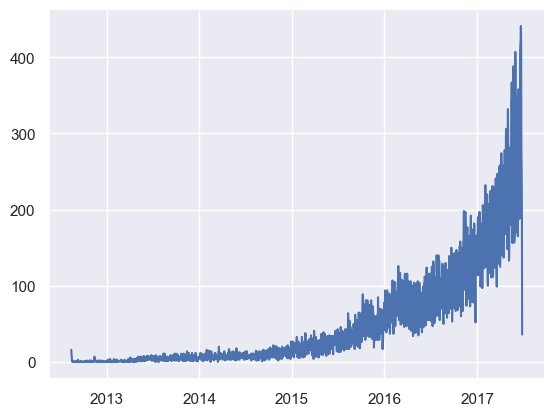

In [16]:
plt.plot(daily_df)

In [18]:
weekly_df = daily_df.resample('W').agg('sum')
weekly_df

posts
                            sum
published                      
2012-08-19 00:00:00+00:00    34
2012-08-26 00:00:00+00:00     4
2012-09-02 00:00:00+00:00     1
2012-09-09 00:00:00+00:00     3
2012-09-16 00:00:00+00:00     4
...                         ...
2017-06-04 00:00:00+00:00  2153
2017-06-11 00:00:00+00:00  2007
2017-06-18 00:00:00+00:00  2163
2017-06-25 00:00:00+00:00  2639
2017-07-02 00:00:00+00:00   243

[255 rows x 1 columns]

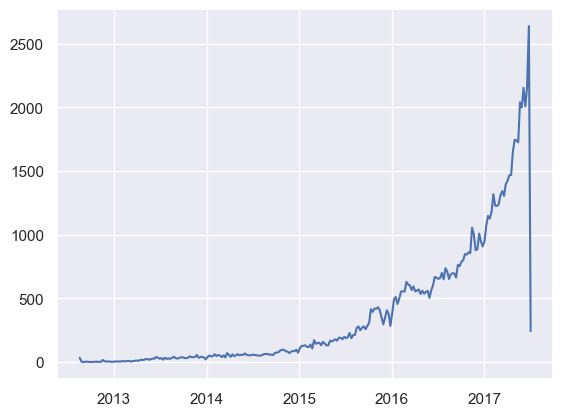

In [19]:
plt.plot(weekly_df)

In [21]:
daily_df = daily_df[daily_df.index >= '2015-01-01']
daily_df.head()

posts
                            sum
published                      
2015-01-01 00:00:00+00:00     8
2015-01-02 00:00:00+00:00    11
2015-01-03 00:00:00+00:00    11
2015-01-04 00:00:00+00:00     8
2015-01-05 00:00:00+00:00    27

In [29]:
import logging
from prophet import Prophet
logging.getLogger().setLevel(logging.ERROR)

In [27]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df['ds'] = df.ds.dt.tz_convert(None)
df.tail()

ds    y
904 2017-06-23  421
905 2017-06-24  277
906 2017-06-25  253
907 2017-06-26  207
908 2017-06-27   36

In [28]:
pred_size = 30
train_df = df[:-pred_size]
train_df.tail()

ds    y
874 2017-05-24  375
875 2017-05-25  298
876 2017-05-26  269
877 2017-05-27  157
878 2017-05-28  172

In [30]:
m = Prophet()
m.fit(train_df)

00:59:27 - cmdstanpy - INFO - Chain [1] start processing
00:59:27 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
future = m.make_future_dataframe(periods=pred_size)
future.tail()

ds
904 2017-06-23
905 2017-06-24
906 2017-06-25
907 2017-06-26
908 2017-06-27

In [32]:
forecast = m.predict(future)
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
904 2017-06-23  273.243879  252.846698  303.653531   272.957916   273.530200   
905 2017-06-24  273.931242  213.298888  264.226640   273.625124   274.232756   
906 2017-06-25  274.618604  217.362871  268.493250   274.269623   274.949377   
907 2017-06-26  275.305966  264.302605  314.411328   274.922099   275.669270   
908 2017-06-27  275.993328  269.575970  320.630407   275.586778   276.397914   

     additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
904        3.008496              3.008496              3.008496   3.628674   
905      -34.861541            -34.861541            -34.861541 -34.418001   
906      -31.166189            -31.166189            -31.166189 -30.880325   
907       13.705860             13.705860             13.705860  13.855176   
908       17.293874             17.293874             17.293874  17.329416   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
904      3.628674      3.628674 -0.620178     -0.620178     -0.620178   
905    -34.418001    -34.418001 -0.443540     -0.443540     -0.443540   
906    -30.880325    -30.880325 -0.285864     -0.285864     -0.285864   
907     13.855176     13.855176 -0.149316     -0.149316     -0.149316   
908     17.329416     17.329416 -0.035542     -0.035542     -0.035542   

     multiplicative_terms  multiplicative_terms_lower  \
904                   0.0                         0.0   
905                   0.0                         0.0   
906                   0.0                         0.0   
907                   0.0                         0.0   
908                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
904                         0.0  276.252375  
905                         0.0  239.069701  
906                         0.0  243.452415  
907                         0.0  289.011826  
908                         0.0  293.287202

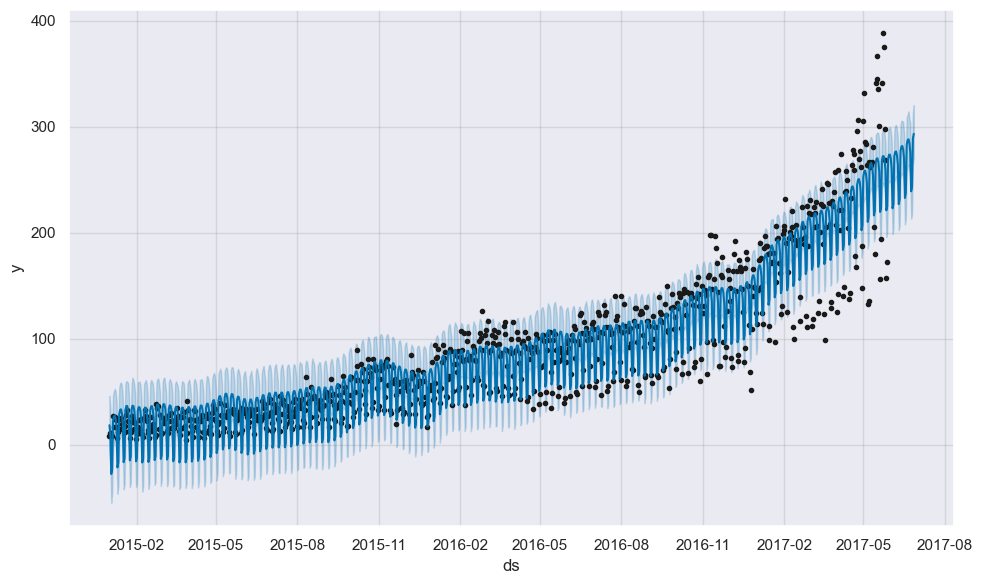

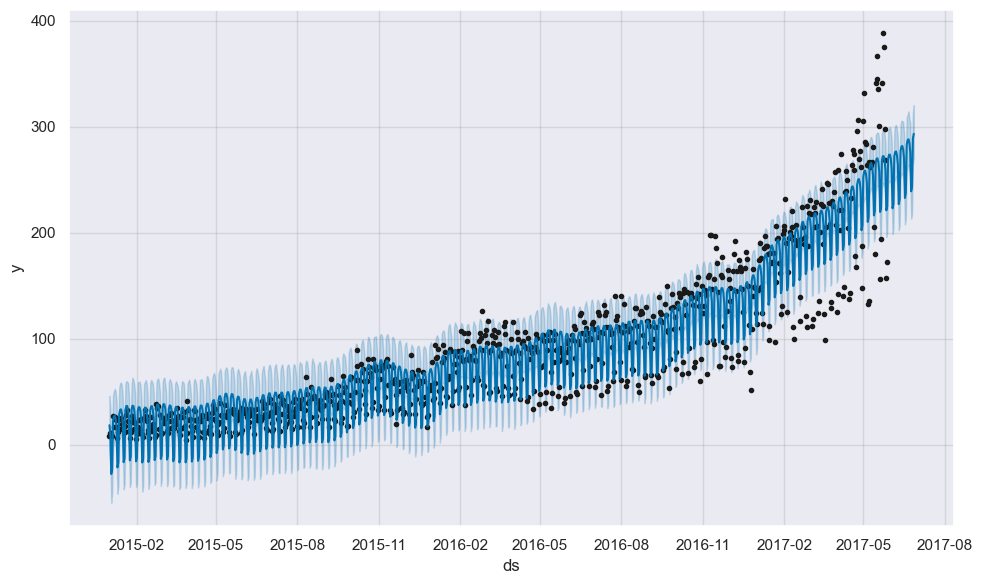

In [35]:
m.plot(forecast)

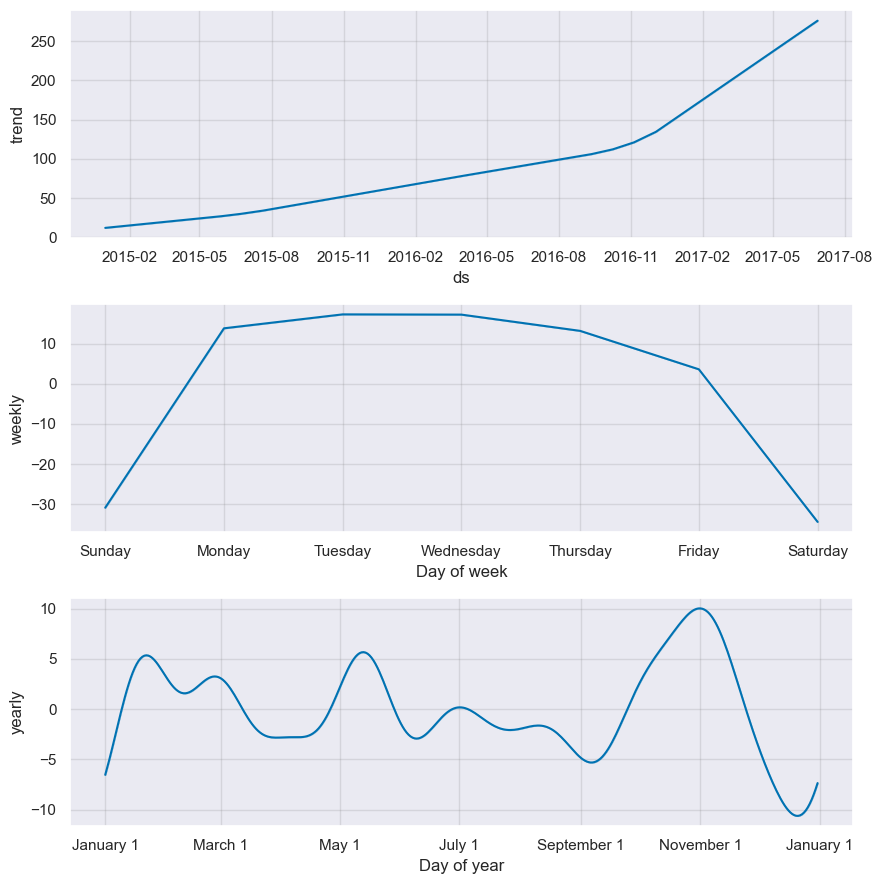

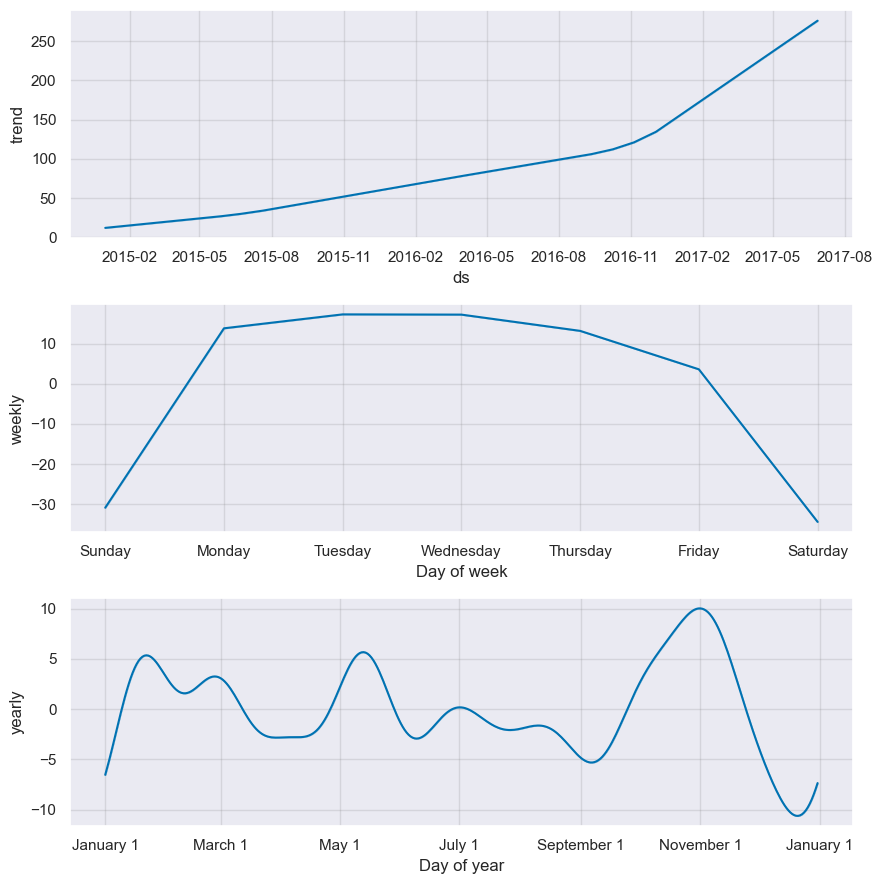

In [36]:
m.plot_components(forecast)

In [37]:
def make_comp_df(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(
        historical.set_index('ds')
    )

In [38]:
cmp_df = make_comp_df(df, forecast)
cmp_df.tail()

yhat  yhat_lower  yhat_upper    y
ds                                                 
2017-06-23  276.252375  252.846698  303.653531  421
2017-06-24  239.069701  213.298888  264.226640  277
2017-06-25  243.452415  217.362871  268.493250  253
2017-06-26  289.011826  264.302605  314.411328  207
2017-06-27  293.287202  269.575970  320.630407   36

In [39]:
def calc_forecast_errs(df, pred_size):
    df = df.copy()
    df['e'] = df.y - df.yhat
    df['p'] = 100 * df.e / df.y
    pred_part = df[-pred_size:]
    err_mean = lambda name: np.mean(np.abs(pred_part[name]))
    return {'MAPE': err_mean('p'), 'MAE': err_mean('e')}

In [42]:
for err_name, err_value in calc_forecast_errs(cmp_df, pred_size).items():
    print(err_name, err_value)

MAPE 45.66307033714285
MAE 79.48831909044951


In [30]:
url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/wiki_machine_learning.csv'
df = pd.read_csv(url, sep=' ')
df.head()

date  count lang              page  rank   month             title
81  2015-01-01   1414   en  Machine_learning  8708  201501  Machine_learning
80  2015-01-02   1920   en  Machine_learning  8708  201501  Machine_learning
79  2015-01-03   1338   en  Machine_learning  8708  201501  Machine_learning
78  2015-01-04   1404   en  Machine_learning  8708  201501  Machine_learning
77  2015-01-05   2264   en  Machine_learning  8708  201501  Machine_learning

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 81 to 372
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    384 non-null    object
 1   count   384 non-null    int64 
 2   lang    384 non-null    object
 3   page    384 non-null    object
 4   rank    384 non-null    int64 
 5   month   384 non-null    int64 
 6   title   384 non-null    object
dtypes: int64(3), object(4)
memory usage: 24.0+ KB


In [32]:
df['date'] = pd.to_datetime(df.date)

In [33]:
from prophet import Prophet

preds = 30
df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

ds     y
382 2016-01-16  1644
381 2016-01-17  1836
376 2016-01-18  2983
375 2016-01-19  3389
372 2016-01-20  3559

In [34]:
train_df = df[:-preds].copy()
m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=preds)
future.tail()

21:44:02 - cmdstanpy - INFO - Chain [1] start processing
21:44:03 - cmdstanpy - INFO - Chain [1] done processing


ds
379 2016-01-16
380 2016-01-17
381 2016-01-18
382 2016-01-19
383 2016-01-20

In [35]:
forecast = m.predict(future)
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
379 2016-01-16  2964.505108  1682.687528  2577.134731  2947.905003   
380 2016-01-17  2969.744425  1810.162663  2696.186467  2952.034106   
381 2016-01-18  2974.983742  2813.726711  3691.030493  2956.037215   
382 2016-01-19  2980.223059  3075.097395  3969.473679  2960.427587   
383 2016-01-20  2985.462376  2963.706349  3851.053394  2964.755109   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
379  2981.582612     -854.511455           -854.511455           -854.511455   
380  2988.199214     -713.520813           -713.520813           -713.520813   
381  2994.877177      288.784838            288.784838            288.784838   
382  3001.056216      548.596799            548.596799            548.596799   
383  3007.140525      432.651651            432.651651            432.651651   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
379 -854.511455   -854.511455   -854.511455                   0.0   
380 -713.520813   -713.520813   -713.520813                   0.0   
381  288.784838    288.784838    288.784838                   0.0   
382  548.596799    548.596799    548.596799                   0.0   
383  432.651651    432.651651    432.651651                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
379                         0.0                         0.0  2109.993653  
380                         0.0                         0.0  2256.223612  
381                         0.0                         0.0  3263.768580  
382                         0.0                         0.0  3528.819857  
383                         0.0                         0.0  3418.114027

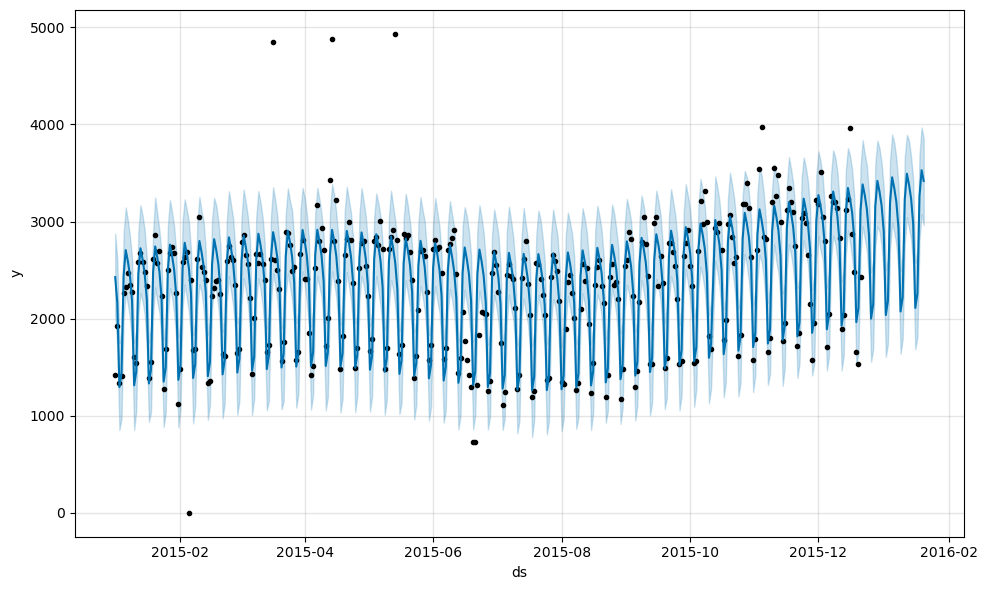

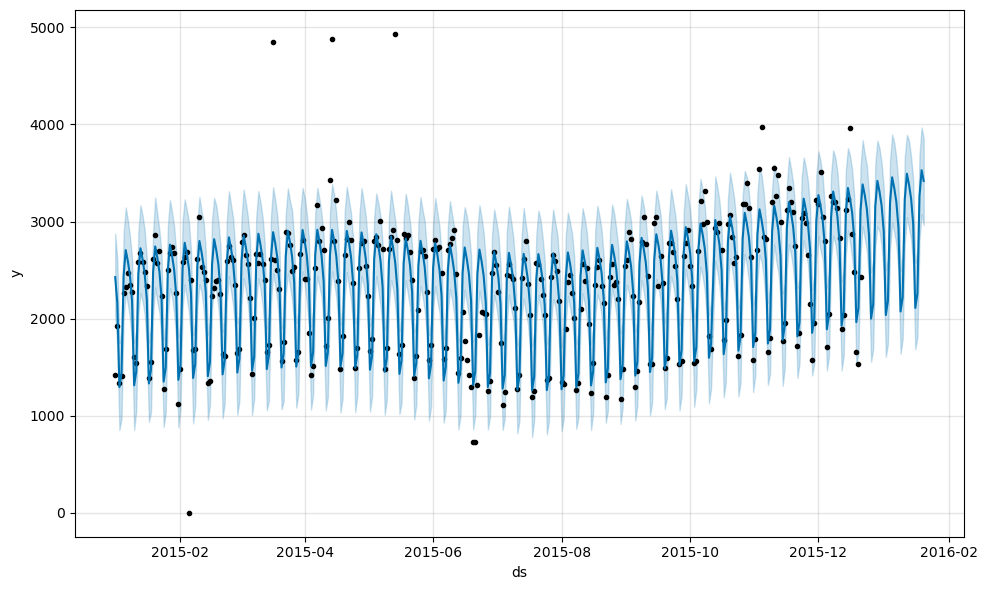

In [36]:
m.plot(forecast)

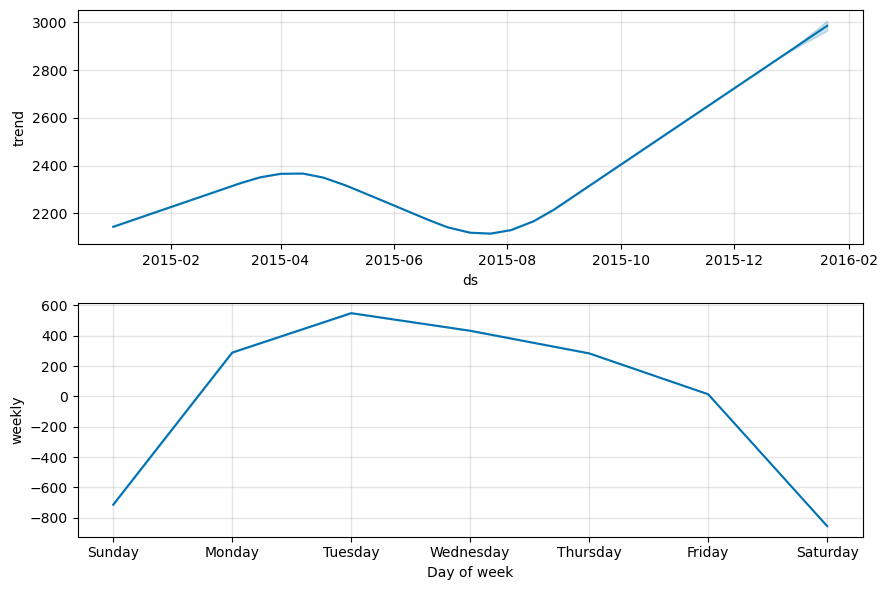

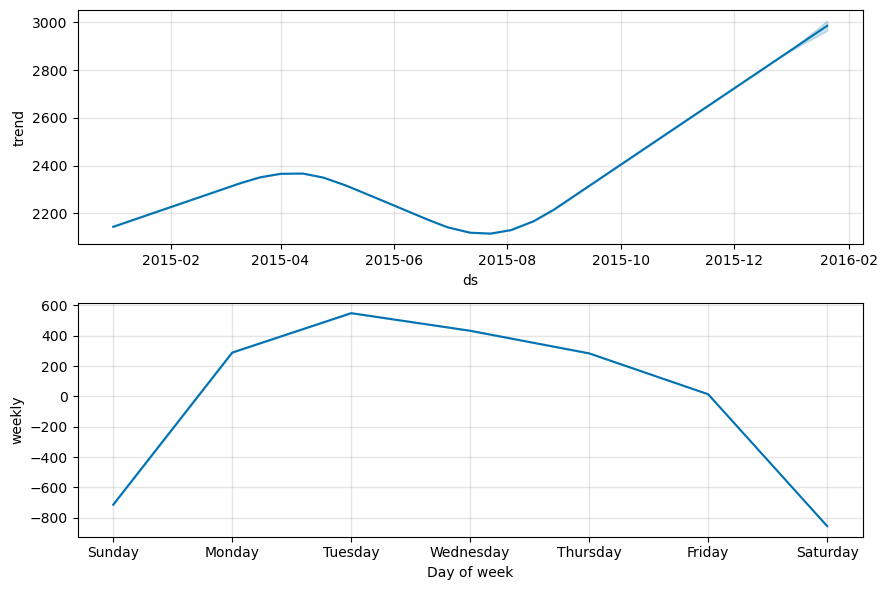

In [37]:
m.plot_components(forecast)

In [38]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(
    df.set_index('ds')
)
cmp_df['e'] = cmp_df.y - cmp_df.yhat
cmp_df['p'] = 100 * cmp_df.e / cmp_df.y
print('mape', round(np.mean(abs(cmp_df[-preds:].p)), 2))
print('mae', round(np.mean(abs(cmp_df[-preds:].e)), 2))

mape 33.94
mae 587.83


In [39]:
plt.rcParams['figure.figsize'] = (15,10)

dickey-fuller test 0.1096859640183851


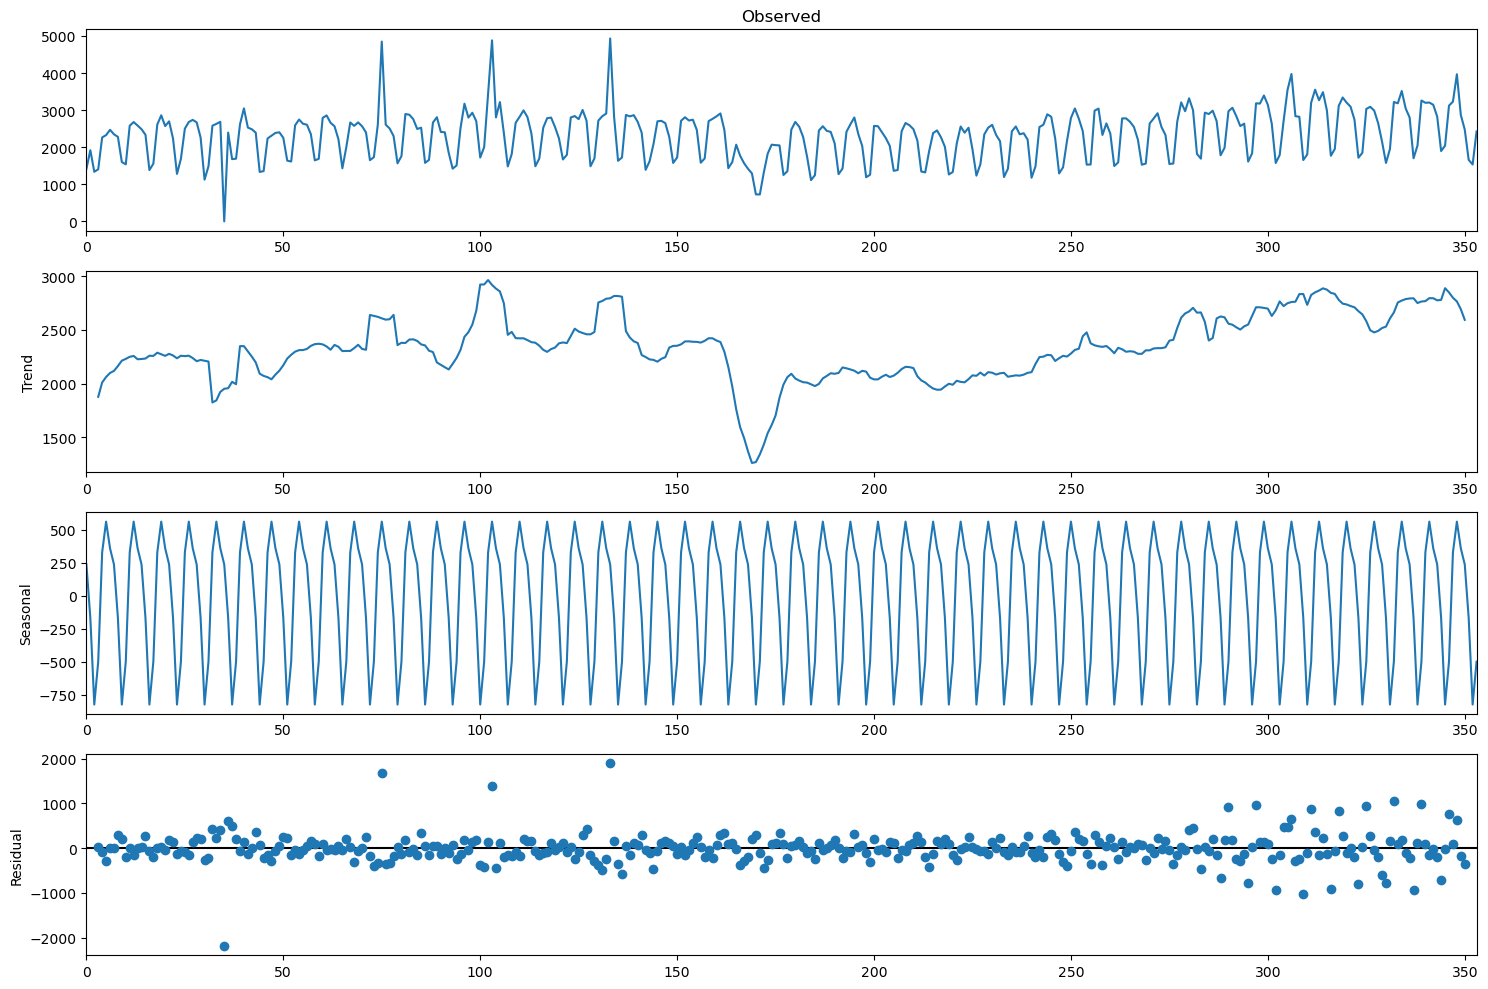

In [40]:
sm.tsa.seasonal_decompose(train_df.y.values, period=7).plot()
print('dickey-fuller test', sm.tsa.stattools.adfuller(train_df.y)[1])

In [41]:
train_df.set_index('ds', inplace=True)

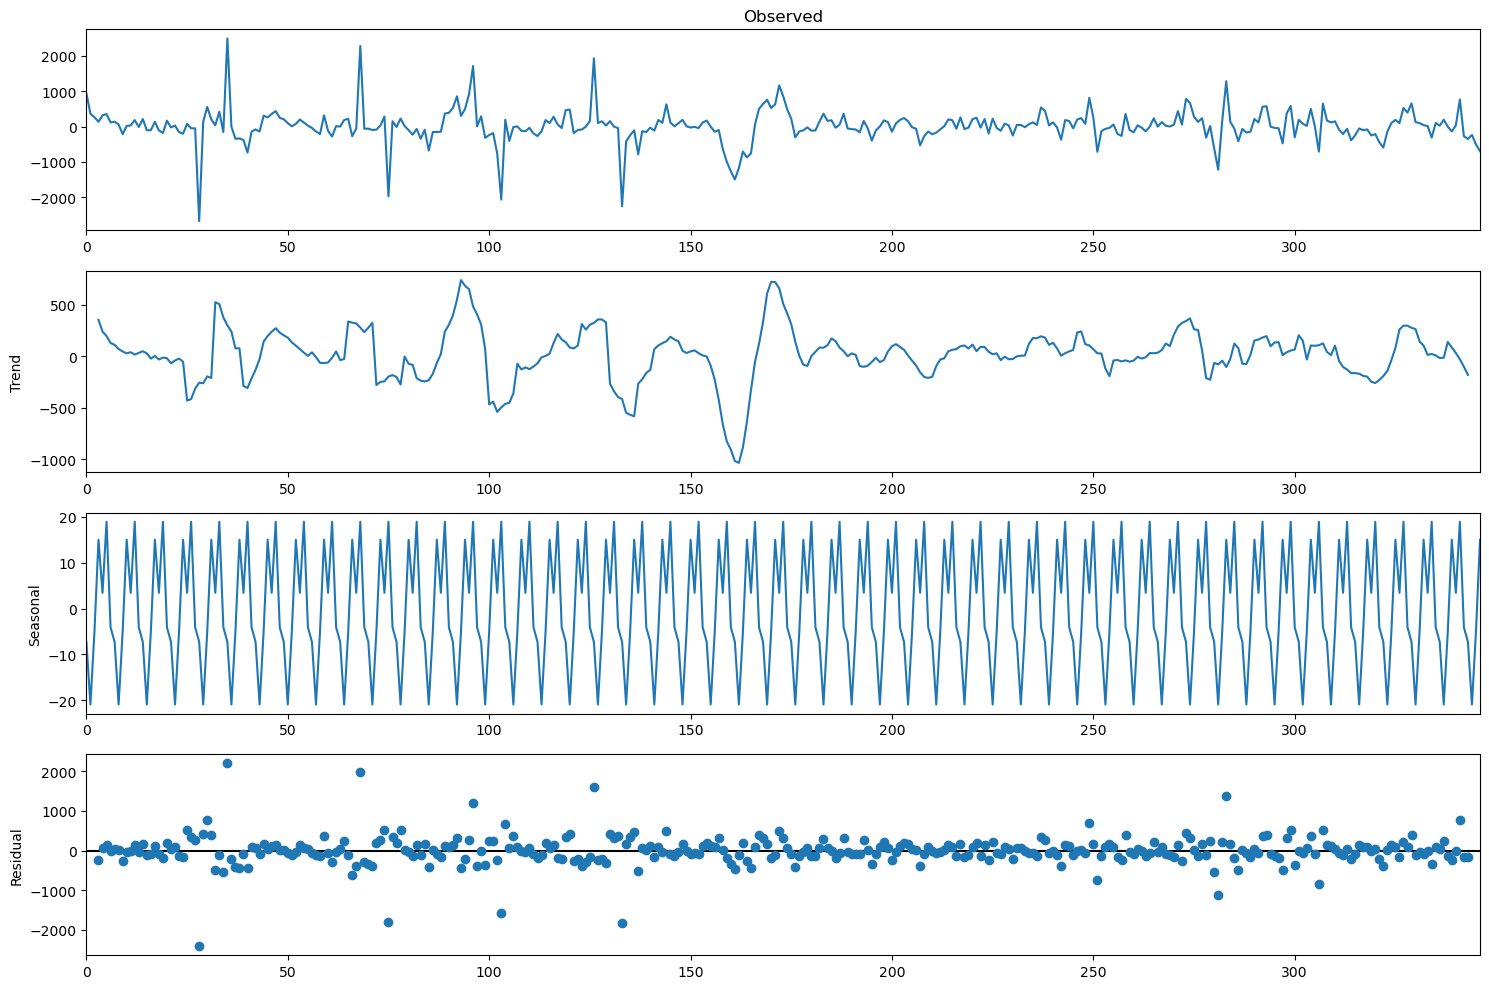

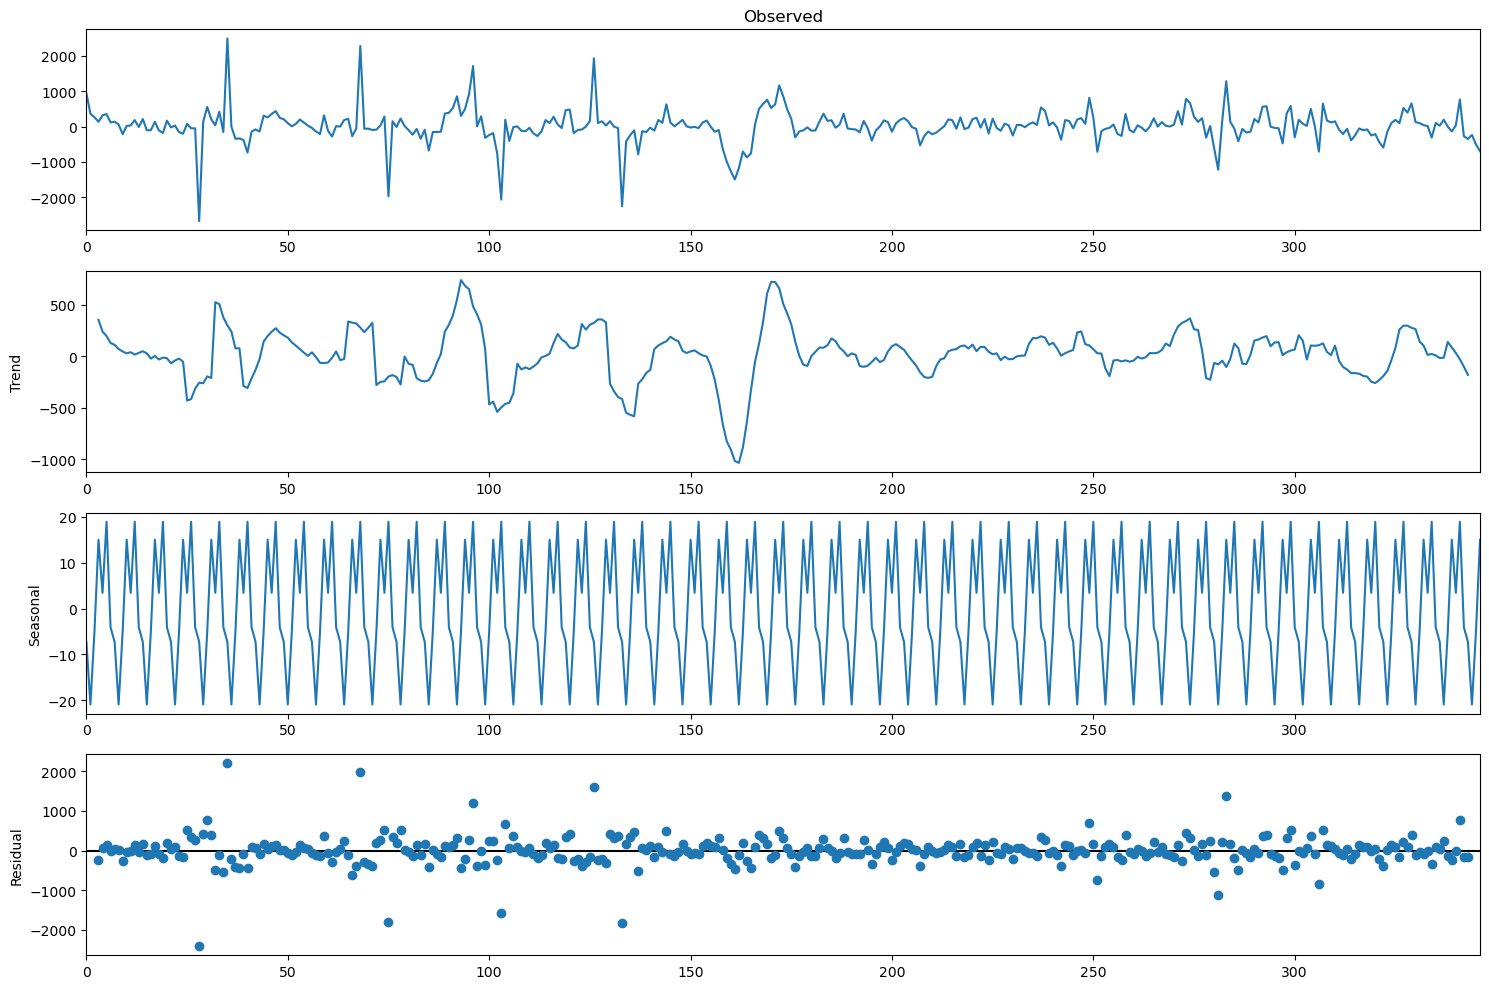

In [42]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot()

C:\Users\serge\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


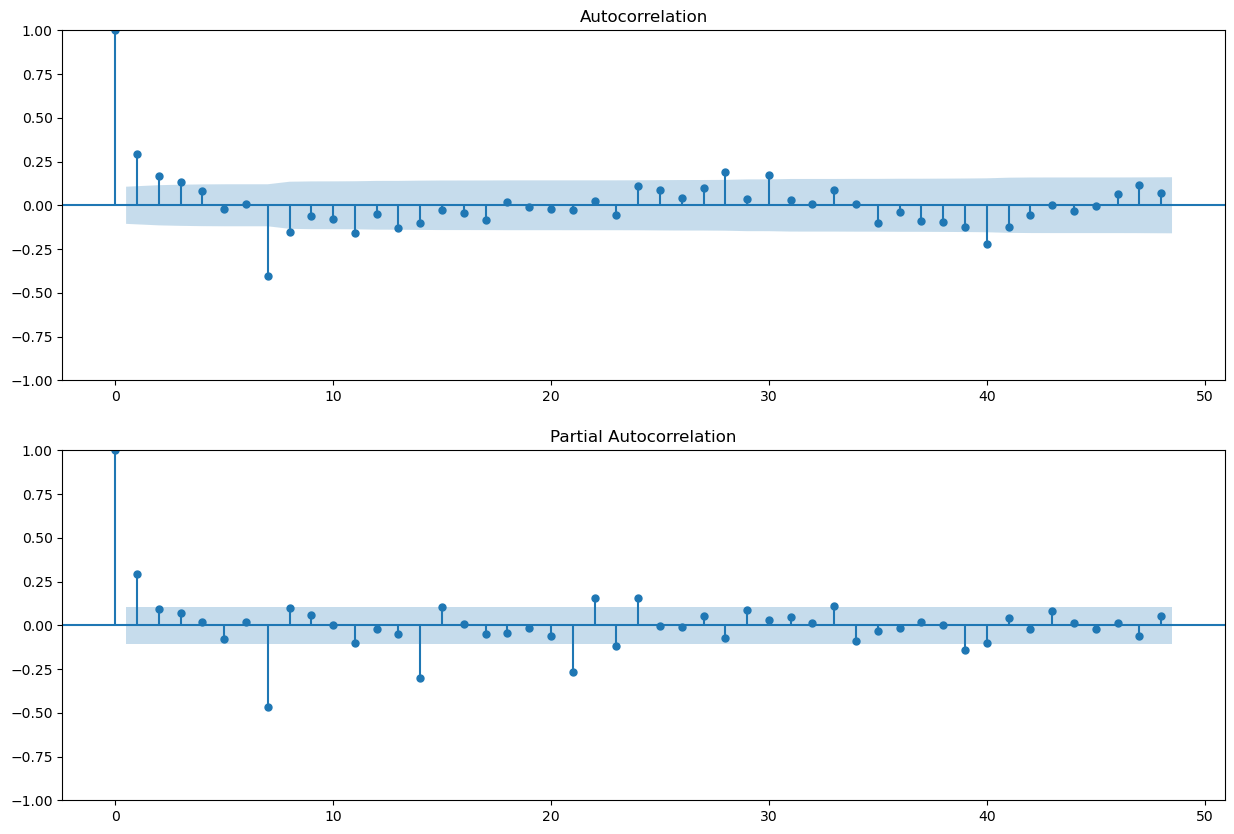

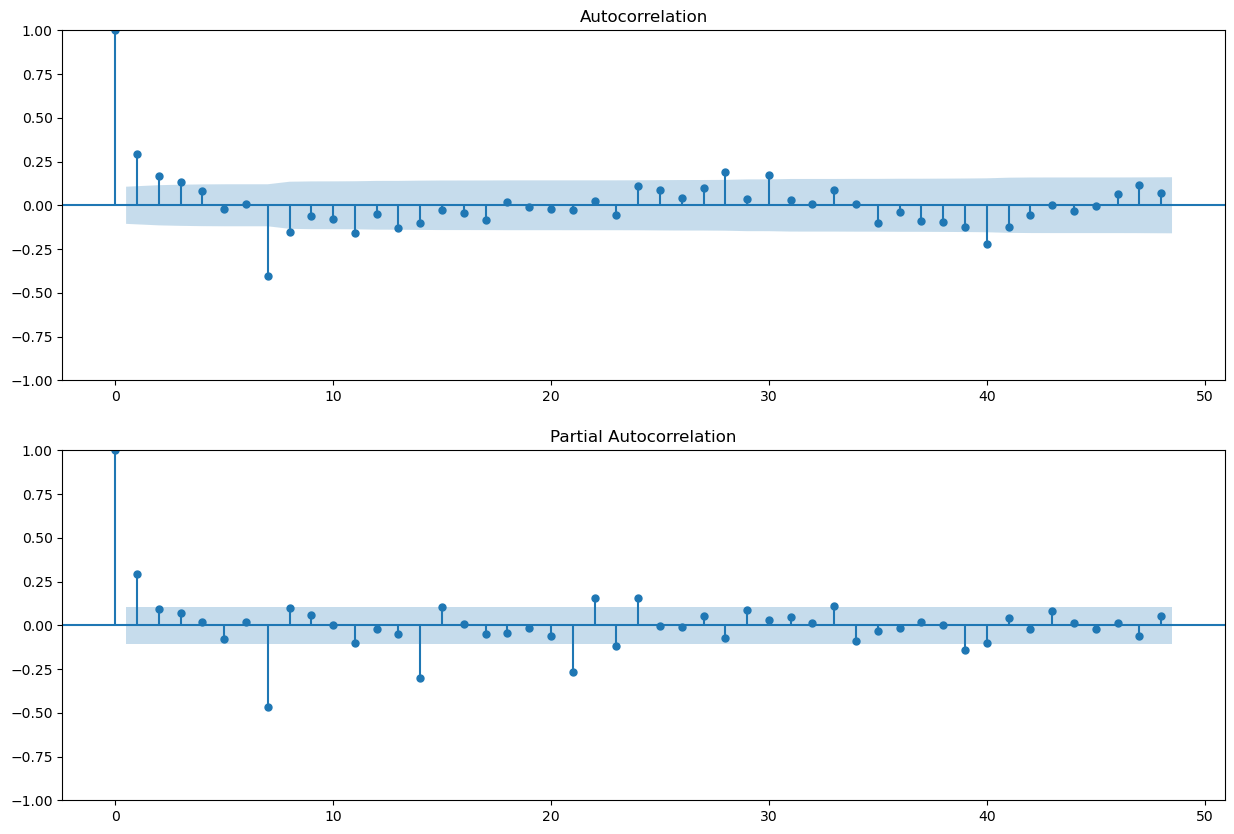

In [44]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)